In [54]:
import numpy as np 
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import jax 
import jax.numpy as jnp
from jax import jit, vmap
import optax
from tqdm import tqdm

In [55]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import constriction 
importlib.reload(constriction) 
from constriction import total_energy2, total_energy, F, h 

In [56]:
# prepare and jit the functions 
E1 = vmap(jit(total_energy), in_axes=(0, None, None))
E2_partial = vmap(jit(total_energy2), in_axes=(None, 0, None, None))
E2 = vmap(E2_partial, in_axes=(0, None, None, None))
E2_diagonal = vmap(jit(total_energy2), in_axes=(0, 0, None, None))

# define the global theta grid and the associated h1, h2 grids 
theta1s = np.linspace(1e-5, np.pi/2*0.99, 100)
h2_R_ratio = np.sin(theta1s)
theta1s_grid, theta2s_grid = np.meshgrid(theta1s, h2_R_ratio)
h1_grid = h(theta1s_grid) 
h2_grid = theta2s_grid/F(theta1s_grid) 
h1_diag = h(theta1s) 
h2_diag = h2_R_ratio/F(theta1s)
mask = (h2_grid > h1_grid) 



def get_energy_landscape(k, nu):
    E = E2(theta1s, h2_R_ratio, k, nu) 

    # Apply the mask to the energy matrix
    masked_array = np.ma.masked_array(E.T, mask=mask)
    min_index = masked_array.argmin(fill_value=np.inf)
    min_index = np.unravel_index(min_index, masked_array.shape)

    # Find minimum energy along the diagonal 
    min_index_diag = np.argmin(E2_diagonal(theta1s, h2_R_ratio, k, nu))

    return masked_array, min_index, min_index_diag 


In [57]:
E1 = vmap(jit(total_energy), in_axes=(0, None, None))
E2_partial = vmap(jit(total_energy2), in_axes=(None, 0, None, None))
E2 = vmap(E2_partial, in_axes=(0, None, None, None))



E2_diagonal = vmap(jit(total_energy2), in_axes=(0, 0, None, None))

theta1s = np.linspace(1e-5, np.pi/2*0.99, 100)
h2_R_ratio = np.sin(theta1s)
k = 0.7
nu = 0.4 # when nu = 0.5, the interface has the same energy as the poles 
E = E2(theta1s, h2_R_ratio, k, nu) 

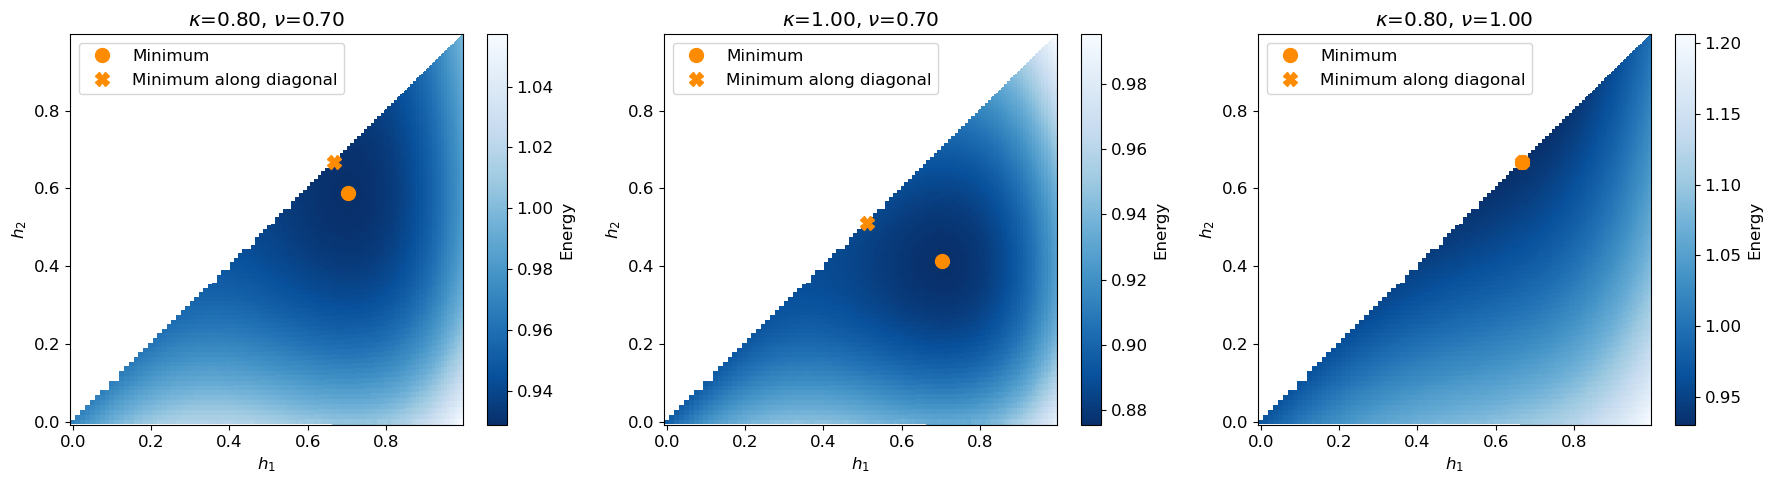

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (k, nu) in enumerate([(0.8, 0.7), (1, 0.7), (0.8, 1)]):

    masked_array, min_index, min_index_diag = get_energy_landscape(k, nu)

    plt.rcParams['font.size'] = 12

    im = axes[i].pcolormesh(h1_grid, h2_grid, masked_array, cmap='Blues_r')
    plt.colorbar(im, ax=axes[i], label='Energy')
    axes[i].plot(h1_grid[min_index], h2_grid[min_index], 'o', color='darkorange', markersize=10, label='Minimum')
    axes[i].plot(h1_diag[min_index_diag], h2_diag[min_index_diag], 'X', color='darkorange', markersize=10, label='Minimum along diagonal')
    axes[i].set_xlabel(r'$h_1$')
    axes[i].set_ylabel(r'$h_2$')
    axes[i].set_title(r'$\kappa$={:.2f}, $\nu$={:.2f}'.format(k, nu)) 
    axes[i].legend(loc='upper left')

plt.tight_layout()
# plt.savefig('../figures/phase2_energy.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
def energy(params, k, nu): 
    theta1, delta = params 
    h2_R_ratio = jnp.sin(theta1 - delta)
    E2_val = total_energy2(theta1, h2_R_ratio, k, nu) 
    return E2_val 

# Setup optimizer
optimizer = optax.adam(learning_rate=0.005)

def find_minimum(k, nu, steps=1000):
    # Initial parameters
    params = jnp.array([np.pi/2*0.9, 0.1])
    opt_state = optimizer.init(params)
    loss_fn = lambda params: energy(params, k, nu)
    
    # One step of optimization
    @jit
    def step(params, opt_state): 
        loss_value, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        
        new_params = new_params.at[0].set(jnp.clip(new_params[0], 0, jnp.pi/2))
        new_params = new_params.at[1].set(jnp.clip(new_params[1], 0, new_params[0]))
        
        return new_params, new_opt_state, loss_value

    # Optimization loop
    for _ in range(steps):
        params, opt_state, loss_value = step(params, opt_state)
    
    return params, loss_value

# Run optimization
optimal_params = [] 
min_energies = [] 
ks = jnp.arange(0.1, 2, 0.1)
nus = jnp.arange(0.1, 1, 0.1)
for k in tqdm(ks):
    for nu in nus:
        p, e = find_minimum(k, nu)
        optimal_params.append(p)
        min_energies.append(e)

 11%|█         | 2/19 [00:02<00:24,  1.45s/it]


KeyboardInterrupt: 

In [8]:
optimal_params = np.array(optimal_params)
print(optimal_params.shape)
min_energies = np.array(min_energies).reshape((len(ks), len(nus)))
theta2 = (optimal_params[:, 0] - optimal_params[:, 1]).reshape((len(ks), len(nus)))
theta1 = optimal_params[:, 0].reshape((len(ks), len(nus)))

h2 = np.sin(theta2)/F(theta1)
h1 = np.sin(theta1)/F(theta1) 

(171, 2)


In [9]:
np.save('sim_data/constriction/theta1.npy', theta1)
np.save('sim_data/constriction/theta2.npy', theta2)
np.save('sim_data/constriction/min_energy.npy', min_energies)


In [60]:
ks = jnp.arange(0.1, 2, 0.1)
nus = jnp.arange(0.1, 1, 0.1)

theta1 = np.load('sim_data/constriction/theta1.npy')
theta2 = np.load('sim_data/constriction/theta2.npy')
min_energies = np.load('sim_data/constriction/min_energy.npy')

h2 = np.sin(theta2)/F(theta1)
h1 = np.sin(theta1)/F(theta1) 

## Load in the heights

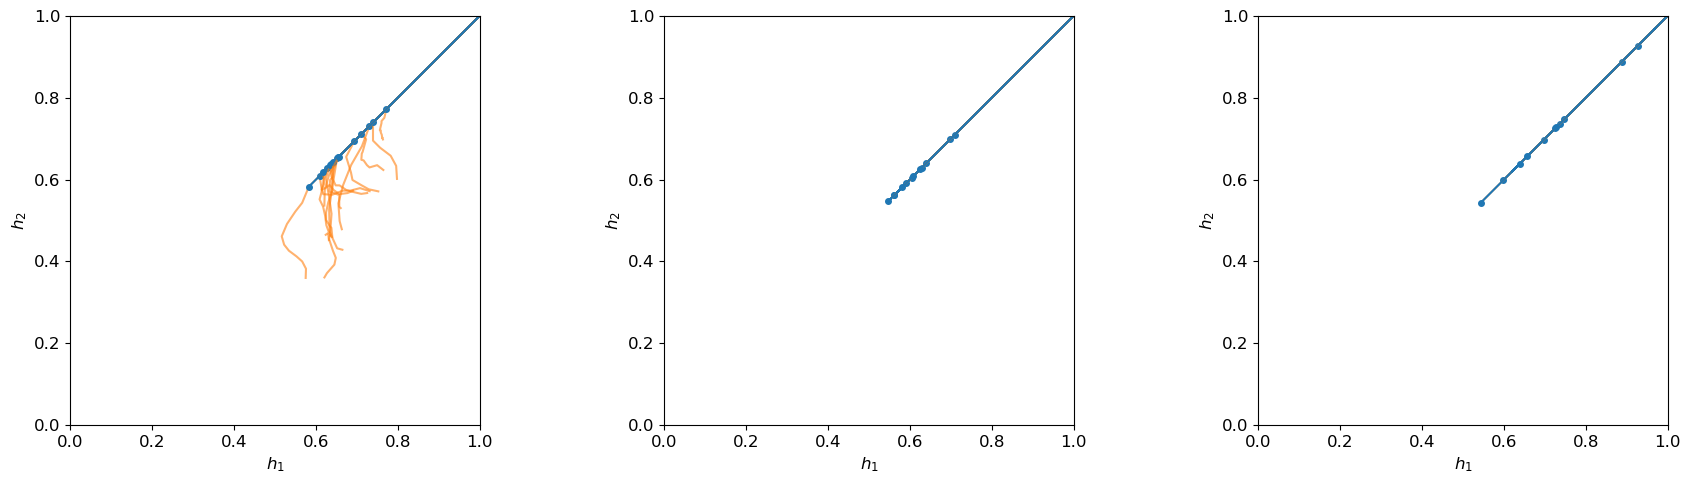

In [61]:

labels = ['wt', 'cafree', 'carhoa']

heights = [] 

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for (l, ax) in zip(labels, axes):
    path = f'../data/furrow_position_h1_h2/furrow_position_{l}/'

    h1s = [] 
    h2s = [] 
    
    for file in os.listdir(path):
        if file.endswith('.npy') and file.startswith('Replicate'):
            data = np.load(os.path.join(path, file))
            h1_data = data[1]/data[1][0]
            h2_data = data[2]/data[1][0]

            h1s.append(h1_data)
            h2s.append(h2_data)

            m = (h1_data == h2_data) 
            
            ax.plot(h1_data, h2_data, '-', alpha=0.6, color='tab:orange', linewidth=1.5)
            ax.plot(h1_data[m], h2_data[m], '-', alpha=1, color='tab:blue', linewidth=1.5)
            ax.plot(h1_data[m][-1], h2_data[m][-1], 'o', color='tab:blue', markersize=4)

    heights.append((h1s, h2s))
            
    ax.set_xlabel(r'$h_1$')
    ax.set_ylabel(r'$h_2$')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    
plt.tight_layout()
plt.show()

h2 final heights:
Mean: 0.521
Std: 0.093

h1 final heights:
Mean: 0.686
Std: 0.064


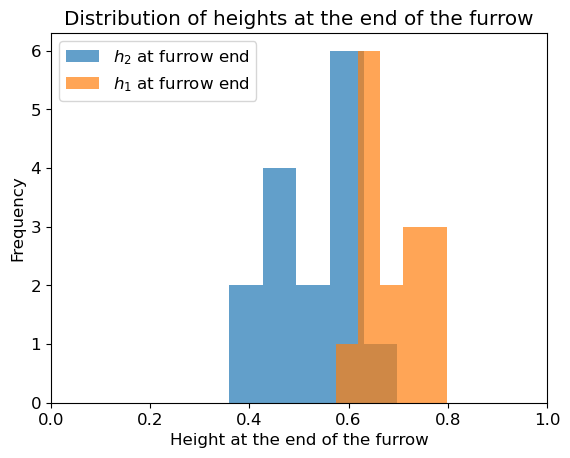

In [62]:
final_h1_heights = np.array([h1_data[-1] for h1_data in heights[0][0]])
final_heights = np.array([h2_data[-1] for h2_data in heights[0][1]])

plt.hist(final_heights, bins=5, color='tab:blue', alpha=0.7, label=r'$h_2$ at furrow end')
plt.hist(final_h1_heights, bins=5, color='tab:orange', alpha=0.7, label=r'$h_1$ at furrow end')
plt.xlabel('Height at the end of the furrow')
plt.ylabel('Frequency')
plt.title('Distribution of heights at the end of the furrow')
plt.xlim(0, 1)
plt.legend()

h1_mean = np.mean(final_h1_heights)
h2_mean = np.mean(final_heights)
h1_std = np.std(final_h1_heights)
h2_std = np.std(final_heights)

print("h2 final heights:")
print(f"Mean: {h2_mean:.3f}")
print(f"Std: {h2_std:.3f}")

print("\nh1 final heights:")
print(f"Mean: {h1_mean:.3f}")
print(f"Std: {h1_std:.3f}")

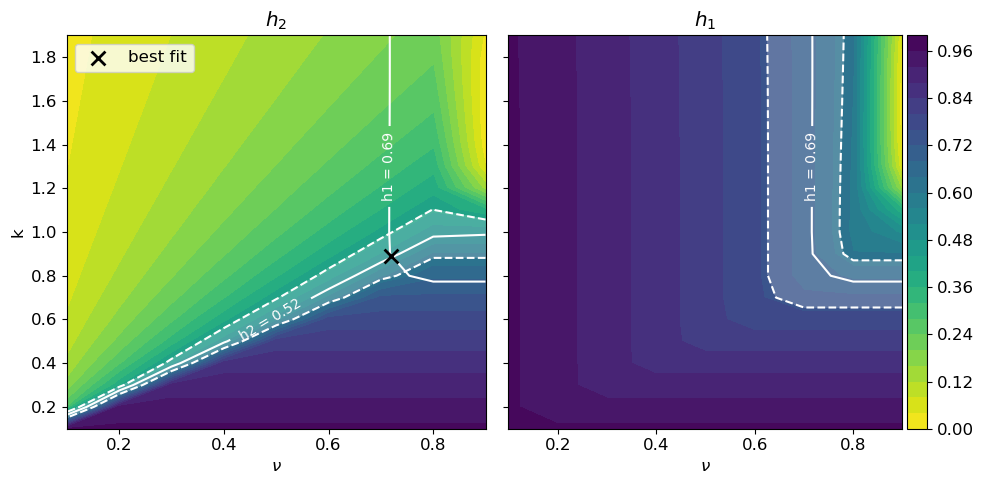

In [67]:
plt.rcParams.update({'font.size': 12})

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# First subplot for h2
im1 = ax1.contourf(nus, ks, h2, cmap='viridis_r', vmin=0, vmax=1, levels=30)
ax1.set_xlabel(r'$\nu$')
ax1.set_ylabel(r'k')
ax1.set_title(r'$h_2$')

# Second subplot for h1
im2 = ax2.contourf(nus, ks, h1, cmap='viridis_r', vmin=0, vmax=1, levels=30)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax)
ax2.set_xlabel(r'$\nu$')
ax2.set_title(r'$h_1$')

line_color = 'white'
# Add contour lines with different styles
contour1 = ax1.contour(nus, ks, h2, levels=[h2_mean - h2_std, h2_mean, h2_mean + h2_std], colors=line_color, linewidths=1.5, linestyles=['--', '-', '--'])
contour2 = ax2.contour(nus, ks, h1, levels=[h1_mean - h1_std, h1_mean, h1_mean + h1_std], colors=line_color, linewidths=1.5, linestyles=['--', '-', '--'])
contour3 = ax1.contour(nus, ks, h1, levels=[h1_mean], colors=line_color, linewidths=1.5)

# Add transparent shading between the contour lines
ax1.contourf(nus, ks, h2, levels=[h2_mean - h2_std, h2_mean + h2_std], colors=[line_color], alpha=0.2)
ax2.contourf(nus, ks, h1, levels=[h1_mean - h1_std, h1_mean + h1_std], colors=[line_color], alpha=0.2)

# Add labels to the middle contour lines
ax1.clabel(contour1, levels=[h2_mean], inline=True, fontsize=10, fmt='h2 = %.2f')
ax1.clabel(contour3, levels=[h1_mean], inline=True, fontsize=10, fmt='h1 = %.2f')
ax2.clabel(contour2, levels=[h1_mean], inline=True, fontsize=10, fmt='h1 = %.2f')

ax1.scatter([0.72], [0.89], marker='x', s=100, c='black', linewidths=2, label='best fit', zorder=10) 
ax1.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('../figures/phase2_phase_diagram.png', dpi=500)
plt.show()

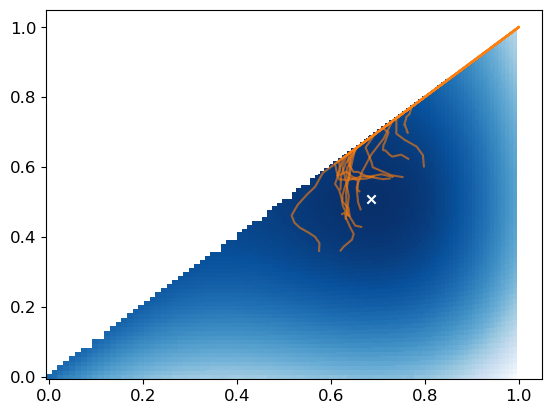

In [ ]:
k_best = 0.89 
nu_best = 0.72 

masked_array, min_index, min_index_diag = get_energy_landscape(k_best, nu_best)

plt.pcolor(h1_grid, h2_grid, masked_array, cmap='Blues_r')
plt.scatter(h1_grid[min_index], h2_grid[min_index], color='white', marker='x', label='Minimum')
# plt.scatter(h1_diag[min_index_diag], h2_diag[min_index_diag], color='red', marker='x', label='Minimum along diagonal', zorder=10)


h1s = heights[0][0]
h2s = heights[0][1]
for h1_traj, h2_traj in zip(h1s, h2s): 
    plt.plot(h1_traj, h2_traj, color='tab:orange', alpha=0.6)

plt.legend() 
plt.show()



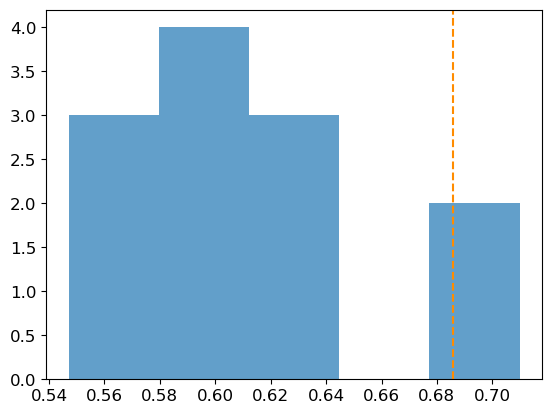

In [86]:
final_heights_cafree = np.array([h1_data[-1] for h1_data in heights[1][0]])

plt.hist(final_heights_cafree, bins=5, color='tab:blue', alpha=0.7, label=r'$h_2$ at furrow end')
plt.axvline(x=h1_grid[min_index], color='darkorange', linestyle='--', label='Minimum $h_1$')
plt.show() 

## Explore the energy when $\theta_1$ is chosen to be the minimum of the phase 1 energy

In [ ]:
thetas = np.linspace(0, np.pi/2*0.99, 100)

k_vals = [0.1, 0.4, 1]
nu_vals = [0.1, 0.5, 1] 

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
alphas = [0.5, 0.8, 1]


for (i, k) in enumerate(k_vals): 
    for (j, nu) in enumerate(nu_vals):
        E_vals, phase_2, E1_vals = combined_energy(thetas, k, nu)
        if phase_2: 
            plt.plot(thetas, E1_vals, linestyle='--', color=colors[i]) 
        plt.plot(thetas, E_vals, label=fr'k={k}, $\nu$={nu}', color=colors[i], alpha=alphas[j])
        plt.plot(thetas[np.argmin(E_vals)], E_vals[np.argmin(E_vals)], 'o', color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$E(\theta)$')
plt.savefig('../figures/phase_2_energy.png', bbox_inches='tight')
plt.show() 

NameError: name 'combined_energy' is not defined

In [8]:
N = 50
k_vals = np.linspace(0, 2, N)
nu_vals = np.linspace(0, 1, N)
minimum_theta = np.empty((N, N))
phase_2_arr = np.empty((N, N), dtype=bool)

for i, k in enumerate(k_vals):
    for j, nu in enumerate(nu_vals):
        E_vals, phase_2, E1_vals = combined_energy(thetas, k, nu)
        minimum_theta[i, j] = thetas[np.argmin(E_vals)]
        phase_2_arr[i, j] = (np.argmin(E_vals) == np.argmin(E1_vals))


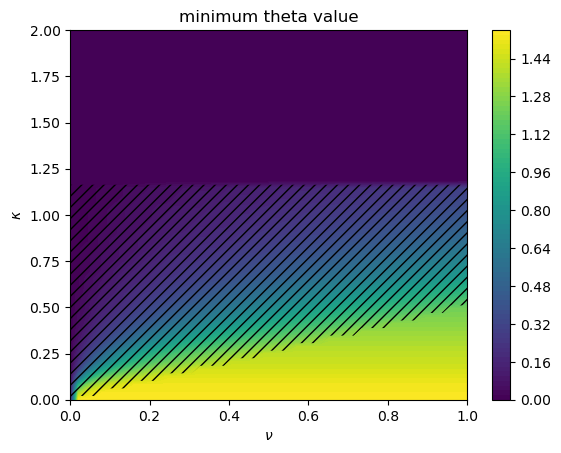

In [9]:

plt.contourf(nu_vals, k_vals, minimum_theta, levels=100)
plt.colorbar()
plt.contourf(nu_vals, k_vals, phase_2_arr, levels=[0, 0.5], colors=['none'], hatches=['///']) 
plt.ylabel(r"$\kappa$")
plt.xlabel(r'$\nu$')
plt.title('minimum theta value')
plt.savefig('../figures/phase2_phase_diagram.png')
plt.show() 